In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import time
import seaborn as sns
from submapp import *
from tools.tools_som import *
from submapp.tools.data_processing import *
from submapp.tools.evaluation import *

## STEP 0: data processing

##### 0.1 Extract data from files

There is nothing to change in this cell, just run the cell to extract data from the netcdf4 file. 
If this does not work, make sure the file ``GotmFabmErsem-BATS.nc`` is in the right folder. (It should be in the same folder as this notebook, ``submapp`` folder and ``tools`` folder )

In [2]:
############ STEP 0.1 ##################################################
# ---- Extracting data
([temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth]) = data_extraction()
gotm_data = [temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth]
data_types = ["temp", "sst", "dswr", "airt", "ws10", "depth"]

for i in range(len(gotm_data)-1):
    for y in range(len(gotm_data[i])):
        gotm_data[i][y] = mean_steps(gotm_data[i][y],10)
[temp_y, sst_y, dswr_y, airt_y, ws10_y ,depth] = gotm_data

##### 0.2 Select data types

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Select the data types you want to work with by initializing the list ``data_types_used`` with some of the following elements 
     - 0: Temperature (temp)
     - 1: Sea surface temperature (sst)
     - 2: Incoming Short Wave Radiation (dswr)
     - 3: Air Temperature (airt)
     - 4: Wind Speed (ws10)
     - (-1): Depth (depth)
     
``Temperature (0)`` is related to the vertical profiles of temperature, in our case they are the "*hidden*" values.

`` Depth (-1)`` is a vector of levels of depth corresponding to the vertical profiles

``Sea surface temperature (1), Incoming Short Wave Radiation (2), Air Temperature (3)`` and ``Wind Speed (4)`` are surface information types. in our case they are the "*observable*" values from which we want to infer *hidden* values

<span style="background-color: ##FFFF00">**NOTE**: </span>

- If you want to work with *hidden* variables then you should only select ``temperature`` then ``data_types_used = [0]``. 
- If you want to work with *observale* variables you are not forced to choose all the observable variables! Actually you should NOT use them all as some of them are highly correlated! In our case we will only use ``sst`` and ``dswr`` but feel free to play with other variables as well! :) 


In [3]:
############ STEP 0.2 ##################################################

# ----------------------------
# TODO: 
# --- Select your data by initializing data_types_used
# - 0: Temperature (temp)
# - 1: Sea surface temperature (sst)
# - 2: Incoming Short Wave Radiation (dswr)
# - 3: Air Temperature (airt)
# - 4: Wind Speed (ws10)
# - (-1): Depth (depth)
data_types_used = [1,2]  # suggested observable variables 
#data_types_used = [0]  # hidden variables
# ----------------------------

##### 0.3 Split dataset

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Select the number of years in the training dataset (between ``0`` and ``16`` in our case). We suggest you choose ``12``

In [4]:
############ STEP 0.3 ##################################################

# ----------------------------
# TODO: 
# ---- Select the number of years in the training dataset (SUGGESTED 12)
nb_years_train = 12
# ----------------------------


# Quick summary -- nothing to do here
print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
if 0 in data_types_used:
    surface=False
    data_y = [gotm_data[0]]
    nb_data_types_used = 1
    p = depth.size
else:
    surface=True
    nb_data_types_used = len(data_types_used)
    data_y = [gotm_data[i] for i in data_types_used]
    p = nb_data_types_used
    

print("DATA TYPE USED : ", [data_types[i] for i in data_types_used])
print("ARE DATA OBSERVABLE: ", surface)

nb_years = len(data_y[0])
print("SIZE OF INPUT VECTORS :", p)
print("NUMBER OF YEARS USED FOR TRAINING: ", nb_years_train)
print("NUMBER OF YEARS USED FOR TESTING: ", nb_years-nb_years_train)
print("TOTAL NUMBER OF YEARS: ", nb_years)

T_y=[]
for y in range(nb_years):
    T = len(data_y[0][y])
    T_y = np.concatenate([T_y, [T]])
    print("YEAR ", str(1992+y), " LENGTH : ", T )
T_y = T_y.astype(int)
print("LENGTH OF THE TRAINING TIME SERIES: ", sum(T_y[:nb_years_train]))
print("LENGTH OF THE TESTING TIME SERIES: ", sum(T_y[nb_years_train:]))
print("TOTAL LENGTH OF THE TIME SERIES : ", sum(T_y))

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
DATA TYPE USED :  ['sst', 'dswr']
ARE DATA OBSERVABLE:  True
SIZE OF INPUT VECTORS : 2
NUMBER OF YEARS USED FOR TRAINING:  12
NUMBER OF YEARS USED FOR TESTING:  4
TOTAL NUMBER OF YEARS:  16
YEAR  1992  LENGTH :  74
YEAR  1993  LENGTH :  73
YEAR  1994  LENGTH :  73
YEAR  1995  LENGTH :  73
YEAR  1996  LENGTH :  74
YEAR  1997  LENGTH :  73
YEAR  1998  LENGTH :  73
YEAR  1999  LENGTH :  73
YEAR  2000  LENGTH :  74
YEAR  2001  LENGTH :  73
YEAR  2002  LENGTH :  73
YEAR  2003  LENGTH :  73
YEAR  2004  LENGTH :  74
YEAR  2005  LENGTH :  73
YEAR  2006  LENGTH :  73
YEAR  2007  LENGTH :  72
LENGTH OF THE TRAINING TIME SERIES:  879
LENGTH OF THE TESTING TIME SERIES:  292
TOTAL LENGTH OF THE TIME SERIES :  1171


##### 0.3.bis [OPT] Emulate missing values

If you want to emulate missing values in your datasets you can specify a probability lower than 1 of getting an element for all instant of the time series.

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Specify ``prob``: define the probability ``p`` ( with ``0 <= p <= 1``) of getting a value for each instant ``t``

- Specify if this probability should be applied for the training phase set and/or the mapping phase:
    - ``complete_data_train = True`` if you want to use the complete dataset for the training phase
    - ``complete_data_map = False`` if you want to use the sparse dataset for the mapping phase

In [5]:
############ STEP 0.3.bis ###############################################
# ----------------------------
# TODO: 
# ---- Select the probability of getting data at each instant t
prob = 1.
# ----------------------------

# ----------------------------
# TODO: 
# ---- Select if the complete dataset should be used for training/mapping
# ---- Or only the sparse dataset
complete_data_train = True
complete_data_map = False
# ----------------------------

# --- Remove data randomly
complete_data = data_y

sparse_data = [[]]*nb_data_types_used
for dtype in range(nb_data_types_used):
    sparse_data[dtype] = [remove_random_data(data, prob=prob) for data in data_y[dtype]]

if complete_data_train:
    data_train = complete_data
else:
    data_train = sparse_data
if complete_data_map:
    data_map = complete_data
else:
    data_map = sparse_data

print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")    

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------


##### 0.4 Standardization

There is nothing to do here, run the cell to standardize the data and have a quick summary about the original data

In [6]:
############ STEP 0.4 ###############################################

# --- Standardization: step 1: find standardization coeff (on the training data set only!)
data_train_tot = [np.concatenate(data[:nb_years_train]) for data in data_train]
data_mean = np.zeros(nb_data_types_used)
data_stdev = np.zeros(nb_data_types_used)
data_max = np.zeros(nb_data_types_used)
data_min = np.zeros(nb_data_types_used)
for i in range(nb_data_types_used):
    data_max[i] = np.max(data_train_tot[i])
    data_min[i] = np.min(data_train_tot[i])
    (_ ,data_mean[i], data_stdev[i]) = standardize(data_train_tot[i])

# --- standardization: step 2: standardize
data_train_norm = [np.empty([]) for y in range(nb_years)]
data_map_norm = [np.empty([]) for y in range(nb_years)]
for y in range(nb_years):
    if len(data_y[0][0].shape) == 1:
        p_tmp=1
    else:
        (_,p_tmp) = data_y[0][0].shape
    data_train_norm[y] = np.concatenate([
        np.reshape(standardize(data_train[i][y], 
                  data_mean[i], 
                  data_stdev[i]),(T_y[y],p_tmp) ) for i in range(nb_data_types_used)], axis=1)
    data_map_norm[y] = np.concatenate([
        np.reshape(standardize(data_map[i][y], 
                  data_mean[i], 
                  data_stdev[i]),(T_y[y],p_tmp) ) for i in range(nb_data_types_used)], axis=1)
    
print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
for i in range(nb_data_types_used):
    print("DATA TYPE: ", 
          data_types[data_types_used[i]],
          " MEAN: ", round(data_mean[i],2),
          " STDEV: ", round(data_stdev[i],2),
          " MIN: ", round(data_min[i],2),
          " MAX: ", round(data_max[i],2))

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
DATA TYPE:  sst  MEAN:  23.67  STDEV:  3.18  MIN:  18.84  MAX:  30.22
DATA TYPE:  dswr  MEAN:  103.01  STDEV:  63.46  MIN:  13.9  MAX:  232.02


## STEP 1: SOM configuration and evaluation

##### 1.1 Choose the shape of the SOM

__Shape (n, m)__

By *shape of the SOM* we mean here its number of row ``n`` and its number of column ``m``.

It is one of the most important parameters and we highly recommend you to test a lot of different shapes. To help you decide on the ratio ``m/n`` you can use the function ``pca_features`` whose first output is the ratio between the 2 first principal components. This ratio can be seen as a suggestion and the second output (the cumulative percentage of explained variance of the first 2 principal components) can be seen as an indicator of relevance of this suggestion. Once again, all this is only about "*suggestion*", "*indication*" and there is no garantee that this will give the best shape nor even a good one. Once again we highly recommend you to try different shapes!

__Total number of classes n*m__

The total number of classes ``nb_class=n*m`` matters as well. If this number is too low the SOM will poorly represent the diversity of the data. If this number is too high the SOM may overfit the training data and significantly loose accuracy when it comes to the testing dataset. This is a very common problem in machine learning 
and there are tons of articles dealing with this issue. If you want to find out more about overfitting, how to detect it and prevent it check out [this article](https://hackernoon.com/memorizing-is-not-learning-6-tricks-to-prevent-overfitting-in-machine-learning-820b091dc42) by Julien Despois from which the 2 following figures are:
<figure>
<img src="img/overfitting01.png" alt="Recognize underfitting and overfitting" width="600" />
<figcaption> <center> Fig.1 - Recognize underfitting and overfitting </center> </figcaption>
<img src="img/overfitting02.png" alt="Overfitting and model complexity" width="500"/>
<figcaption> <center> Fig.2 - Overfitting and model complexity </center> </figcaption>
</figure>

However, in our context, both SOMs we train are to be combined with a HMM. In this situation, the bottom line is the accuracy of the prediction of hidden variables given observable variables and not the accuracy of the SOMs themselves. Another problem here is that the more classes there are, the more parameters there are in the HMM to be estimated. Therefore the more classes there are the more difficult it is to estimate the HMM model, particularly the transition matrix ``Tr`` Indeed, we do not have enough data to estimate properly the probabilities defining its elements. Thus even though both SOMs are not overfitting the training dataset we may have to train new SOMs with fewer classes according to the output of the HMM. 

The accuracy of the hidden SOM is important though since it defines the best accuracy the HMM can reach. Indeed, in the ideal case your HMM estimates the best classes possible therefore the only error made is the difference between the *true values* and the referent vector representing these *true values* 

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Specify ``n`` the number of rows and ``m`` the number of columns

In [7]:
############ STEP 1.1 ###############################################

#  Apply PCA on the training dataset. 
# - r: ratio between the first 2 principal components. 
# - c_v: cumulative variance of the first 2 principal components. 
r, c_v = pca_features(remove_nan(np.concatenate(data_train_norm[:nb_years_train])))

# ----------------------------
# TODO:
# ---- Select the number of class and the shape of the SOM
# For instance (n,m) = (5,80) for hidden variables and (n,m) = (5,15) for observable variables
n = 7
m = 20
# ----------------------------

print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
print("RATIO PC1/PC2: ", round(r,2), "\nCUMULATIVE VARIANCE: ", c_v)
print("SHAPE OF THE SOM :  (", n, "x", m, ")")
print("RATIO m/n:  ", round(m/n,2))
print("TOTAL NUMBER OF CLASSES: ", n*m)

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
RATIO PC1/PC2:  2.62 
CUMULATIVE VARIANCE:  1.0
SHAPE OF THE SOM :  ( 7 x 20 )
RATIO m/n:   2.86
TOTAL NUMBER OF CLASSES:  140


##### 1.2 SOM initialization

###### 1.2.1 SOM name and path

If you want to save your ``Som`` object you should customize the name your ``Som`` object and the relative paths at which the objects have to be saved by default to make it easier to load them afterwards. 

<span style="background-color: ##FFFF00">**TO DO**: (Optional)</span>

- Customize the name of the SOM
- Customize the default relative path at which the Som object will be saved
- Customize the default relative path at which the figures will be saved
- Customize the default relative path at which the Map2d object will be saved

In [8]:
############ STEP 1.2 ###############################################

############ STEP 1.2.1 ###############################################

# Retrieve the name of the data type used to customize the path
data_name = ""
for i in data_types_used:
    data_name = data_name + data_types[i] + "-" 
data_name=data_name[:-1]

# ----------------------------
# TODO: (Optional)
# ---- Customize the different default paths
path_fig = "figs/Map/" + data_name + "/" + str(n) + "-" + str(m) +"/" + str(int(prob*100)) +'/'
path_som = "objects/Som/" + data_name + "/" + str(n) + "-" + str(m) +"/" + str(int(prob*100)) +'/'
path_map = "objects/Map/" + data_name + "/" + str(n) + "-" + str(m) +"/" + str(int(prob*100)) +'/'
# ----------------------------

# ----------------------------
# TODO: (Optional)
# ---- Customize the name of the Som object
name="1992-"+str(1992+nb_years_train-1)+"_trained"
# ----------------------------

print("------------------------------------------------")
print("#################### SUMMARY ###################")
print("------------------------------------------------")
print("NAME OF THE SOM: ", name )
print("FIGS DIRECTORY: ",path_fig)
print("SOM DIRECTORY: ",path_som)
print("MAP DIRECTORY: ",path_map)

------------------------------------------------
#################### SUMMARY ###################
------------------------------------------------
NAME OF THE SOM:  1992-2003_trained
FIGS DIRECTORY:  figs/Map/sst-dswr/7-20/100/
SOM DIRECTORY:  objects/Som/sst-dswr/7-20/100/
MAP DIRECTORY:  objects/Map/sst-dswr/7-20/100/


###### 1.2.2  SOM and weights initialization

Once the shape of the SOM is chosen, we can initialize our object ``mySom`` from the class ``Som``.

Then weights have to be initialized. The initialization may influence:
- The learning speed: 
  - How many iterations are necessary before getting good results?
- The internal organization of the SOM: 
  - Where are the neurons representing the main features of the data? 
  - Are they organized in specialized areas? 
  - Are some areas redundant? 
  - Are all important features represented by a specialized area?  
  - Can we identify clearly the neurons representing the spring, the cool down, etc?
- Final performance (after the training)

The learning rate and the radius of the neighborhood function can limit this influence. Indeed if both initial learning rate and radius are high, the very first inputs will re-organize the whole SOM almost independently of the initial state of the SOM.  However a good initialization may ensure a stable and coherent internal structure of the SOM, making it a bit less sensitive to the (ir)relevance of the learning rate and radius values chosen. 


Weights can be initialized in many ways and none of them is better than all others in all cases so once again this is one of the steps in which multiple attempts should be made and analyzed before making a final decision. 
There are mainly 3 different approaches:
- Random initialization: each weight is a sample drawn from a distribution (Gaussian or a uniform for example)
- Sample initialization: each weight is a sample drawn from the training dataset
- Data analysis based initialization: each weight is spanned by eigenvectors of the input dataset or a referent vector of a K-means method, etc.

Here you can use one of these methods
- ``random_weights_initialization``: Initializes weights randomly with a gaussian or uniform distribution
- ``pca_weights_initialization``: Initializes weights by applying a PCA on athe training dataset
- ``sample_weights_initialization``: Initializes weights with a sample of the training data
- ``zeros_weights_initialization``: Initializes all weights to zeros vectors

Otherwise you can specify your own weights when initializing the Som object

<span style="background-color: ##FFFF00">**TO DO**: </span>

- Initialize the weights

<span style="background-color: ##FFFF00">**TO DO**: (Optional) </span>
- Try different initialization and observe the differences by runnning the next cell (step 1.2.3)

In [9]:
############ STEP 1.2.2 ###############################################

# Initialize the Som object 
mySom = som.Som(n,m,p,weights=None,name=name,data_mean=data_mean,data_stdev=data_stdev)

# ----------------------------
# TODO:
# ---- Initialize the weights with one of these methods 
# ---- (or None of them but in that case specify your own weights when initializing the Som object)
mySom.random_weights_initialization(distribution="gaussian")
mySom.pca_weights_initialization(np.concatenate(data_train_norm[:nb_years_train]))
mySom.sample_weights_initialization(np.concatenate(data_train_norm[:nb_years_train]))
#mySom.zeros_weights_initialization()
# ----------------------------

###### 1.2.3 Weights visualization

Now that our weights are initiliazed we can try to visualize them

These plots can help you understand how weights initialization works but also how hard it is to interpret and visualize weights! 

DATA TYPE :  sst
VALUE OF EVERY WEIGHT OF THE SOM 


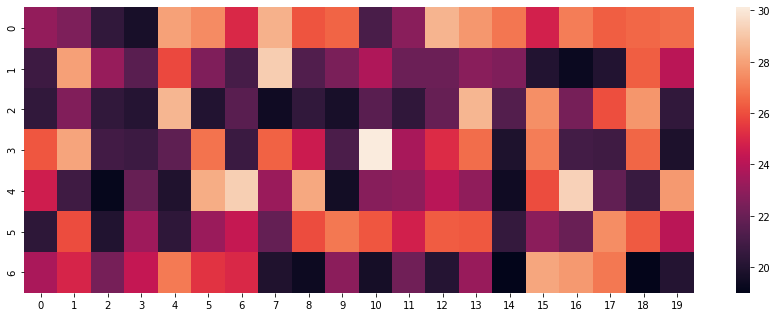

DATA TYPE :  dswr
VALUE OF EVERY WEIGHT OF THE SOM 


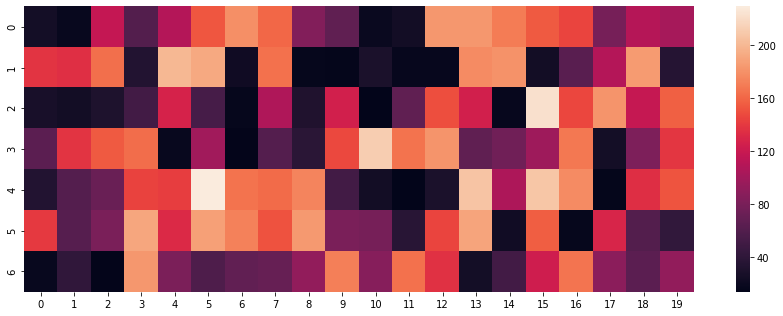

In [10]:
############ STEP 1.2.3 ###############################################

if not surface or p>1:
    # If we are using observable variables, each element of the vector represents a different type of data
    # and should be treated separately
    if surface:
        for i in range(nb_data_types_used):
            print("DATA TYPE : ", data_types[data_types_used[i]])
            print("VALUE OF EVERY WEIGHT OF THE SOM ")
            weights_mean = mySom.weights_features(features="mean",start=i,end=i+1)
            mySom.print_heatmap(weights_mean)
    # If we are using hidden variables, each element of the vector represents a different level of depth 
    # of the temperature vertical profile and we can "average" them to make the plotting easier to interpret 
    else:
        print("TEMPERATURE, AVERAGE VALUE (ALL LEVELS OF DEPTH) OF EVERY WEIGHT OF THE SOM ")
        weights_mean = mySom.weights_features(features="mean")
        mySom.print_heatmap(weights_mean)
        print("TEMPERATURE, STANDARD DEVIATION (ALL LEVELS OF DEPTH) OF EVERY WEIGHT OF THE SOM ")
        weights_dev = mySom.weights_features("std")
        mySom.print_heatmap(weights_dev)
        parts = 4  # the whole profiles will be decomposed into 4 smaller profiles 
        for i in range(parts):
            start=i*p//parts
            end=(i+1)*p//parts
            print("TEMPERATURE, AVERAGE VALUE(LEVELS OF DEPTH", p-start, "TO", p-end,")" )
            weights_mean = mySom.weights_features(features="mean",start=start,end=end)
            mySom.print_heatmap(weights_mean)
            print("TEMPERATURE, STANDARD DEVIATION (LEVELS OF DEPTH", p-start, "TO", p-end,")" )
            weights_std = mySom.weights_features(features="std",start=start,end=end)
            mySom.print_heatmap(weights_std)

##### 1.3 SOM training

Here a quick reminder about the training phase. 

```
1. Find the Best Matching Unit (BMU): class whose referent vector is the closest to the input
2. Update every referent vector: 
    1. compute the distance between the class associated with the referent vector and the BMU (in the map)
    2. update the referent vector so that the closer their associated class is to the BMU (in the map) the more their referent vector will be modified towards the input data.
```

Thus - for instance - for each instant $t$, given the input vector $x_t$ and knowing that the winning neuron is $c$ the weight $w_{i,j}$ is updated as follows:

$$w_{i,j} = w_{i,j} + \alpha \times h(w_{i,j},c) \times [w_{i,j}-x_t] $$

with:
$$ h(w_{i,j},c) = exp(\frac{dist(w_{i,j},c)}{ \sigma^{2} } )$$

$$ dist(w_{i_1,j_1},w_{i_2,j_2}) = ||i_1-i_2|| + ||j_1-j_2||$$

###### 1.3.1 Choose hyperparameters 

Before training our SOM we will have to choose (a lot of) hyperparameters. 
Here a quick description of some of them:

- **Learning rate** $\alpha$: ($0<\alpha<1$)

  Determine the *rate* (or *speed*) of learning. 

  - If $\alpha$ is too high: the SOM won't be adaptive but will only reproduce its last training inputs. 

  - If $\alpha$ is too low: the SOM won't learn fast enough and the weights won't be representative enough of the data at the end of the training. 

  The learning rate should decrease over the training. In our case $\alpha$ decreases linearly after each input vector from ``a0`` to ``aT`` after ``T_train`` inputs but it could have been a exponential decay of an inverse decay as well.
  

- **Radius** $\sigma$:  ($0<\sigma$)

  Determine the *radius* of the neighborhood function $h$. The neighborhood function determines how *much* neurons should learn around the *BMU* (Best Matching Unit: the neuron that was the closest to the input vector). Thus in other words, $\sigma$ determines how *many* neurons will learn around the BMU 

  - If $\sigma$ is too high, too many neurons will be activated by a given input through the neighborhood function. As a consequence some neurons might get redundant and therefore useless while some features of the input data will be poorly represented by the (fewer) remaining neurons 

  - If $\sigma$ is too low, the different areas will specialize too slowly. It could have different unwanted consequences: 
    - Multiple small areas corresponding to similar data features instead of a bigger one. It is important that one and only one area exists for a given functionality such as representing the spring because the distance covered in the SOM between the BMU at instant ``t`` and ``t-1`` must be short so that we can use neighboring functions in the HMM. Some rare transitions can be long since some springs might look like autumn sometimes but this must remain an exception!
    - Undertraining: some neurons are not trained enough because they are always too far from the *BMU* with respect to the radius.

  The radius rate should decrease over the training. In our case $\sigma$ decreases linearly after each input vector from ``s0`` to ``sT`` after ``T_train`` inputs but it could have been a exponential decay of an inverse decay as well.


- **Epochs**:

  Determine the number times that the entire training dataset will train the SOM. 

  During the training phase or once the training is over, plots showing the error with respect to the epochs (sometimes called learning curves) can help to detect overfitting or underfitting. However if the learning rate and the radius decrease enough over the training and if the model is not too complex (total number of classes too high) there should not be overtraining due to a number of epochs too high. 

- **But also...**

  There are more hyperparameters such as the __distance function__ $dist(w_{i_1,j_1},w_{i_2,j_2})$ (parameter ``distance_matrix`` while initializing the Som) which determines whether the SOM is a rectangular or an hexagonal map for instance or the __cost function__ that determines the meaning of "Best Matching Unit". However, they are beyond the scope of this tutorial and the idea behind the training remains the same. Here we use a rectangular map with the euclidean norm as cost function.

###### 1.3.2 Train

Once all the hyperparameters are initialized we can start the training. 
To do so we use the method ``train`` that updates the weights of the SOM according to the formula above. We repeat the operation ``epochs`` times over the entire training dataset.

<span style="background-color: ##FFFF00">**TO DO**:</span>

- Initialize the number of epochs ``epochs``
- Initialize the hyperparameters ``(a0,aT,s0,sT)``
- Customize how the learning rate and the radius both decrease over the training

In [11]:
############ STEP 1.3 ###############################################

############ STEP 1.3.1 #############################################
# ----------------------------
# TODO:
# ---- Initialize hyperparameters
epochs = 10  # number of epochs
a0 = 0.9  # initial learning rate
aT = 0.7  # final learning rate (after the first epoch)
if surface:
    s0 = 5.  # initial radius 
    sT = 1  # final radius
else:
    s0 = 20.  # initial radius 
    sT = 1  # final radius    
# ----------------------------

param = (a0,aT,s0,sT)
T_train = len(np.concatenate(data_train_norm[:nb_years_train]))

############ STEP 1.3.2 #############################################
for e in range(epochs):
    print("#### Epoch : ", e, " ####")
    # A random year is selected from the learning dataset in order not to favor one year over another 
    for y in random.sample(range(nb_years_train), nb_years_train):
        # Train the SOM with one more year from the training dataset 
        inputs = data_train_norm[y]
        mySom.train(
            data_train=inputs, 
            param=param, 
            T_train=T_train
        )
        # Map the whole testing dataset to evaluate how the SOM has improved since the last training
        inputs = np.concatenate(data_map_norm[nb_years_train:])
        mySom.map(data_map=inputs)
    # ----------------------------
    # TODO: 
    # ---- Hyperparameters can be updated after each epoch for a better control over the training
    a0=aT
    aT=max(aT/1.5,0.01)
    s0=sT
    sT=max(sT/1.2,0.5)
    # ----------------------------
    param = (a0,aT,s0,sT)

#### Epoch :  0  ####
Graph initialization
73  vectors have trained the SOM  0.12  sec
292  vectors mapped in  0.17  sec
73  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.19  sec
74  vectors have trained the SOM  0.13  sec
292  vectors mapped in  0.19  sec
74  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.2  sec
73  vectors have trained the SOM  0.11  sec
292  vectors mapped in  0.18  sec
73  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.18  sec
73  vectors have trained the SOM  0.12  sec
292  vectors mapped in  0.19  sec
73  vectors have trained the SOM  0.12  sec
292  vectors mapped in  0.19  sec
74  vectors have trained the SOM  0.11  sec
292  vectors mapped in  0.17  sec
73  vectors have trained the SOM  0.09  sec
292  vectors mapped in  0.17  sec
73  vectors have trained the SOM  0.12  sec
292  vectors mapped in  0.18  sec
73  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.18  sec
#### Epoch :  1  ####
Grap

292  vectors mapped in  0.19  sec
73  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.18  sec
73  vectors have trained the SOM  0.09  sec
292  vectors mapped in  0.17  sec
73  vectors have trained the SOM  0.09  sec
292  vectors mapped in  0.2  sec
74  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.19  sec
74  vectors have trained the SOM  0.09  sec
292  vectors mapped in  0.18  sec
73  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.2  sec
#### Epoch :  9  ####
Graph initialization
73  vectors have trained the SOM  0.09  sec
292  vectors mapped in  0.18  sec
74  vectors have trained the SOM  0.11  sec
292  vectors mapped in  0.21  sec
73  vectors have trained the SOM  0.09  sec
292  vectors mapped in  0.18  sec
73  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.18  sec
74  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.2  sec
73  vectors have trained the SOM  0.1  sec
292  vectors mapped in  0.19  

##### 1.4 SOM evaluation

Model evaluation corresponds to the question "Are results satisfying?". This is a very hard question and even more in our case in which we combine 2 machine learning methods. Indeed, the performance is determined by the estimation of hidden variables given observable variables and not by the accuracy of the SOMs themselves.

Besides, one of the objectives of combining SOM and HMM is to use neighboring functions that propagate probabilities or penalize long transitions. However using these functions is relevant only if the internal structure of both SOM is consistent and represent well the topology of the data. As a consequence in our situation, making sure that the different areas within the SOM are all relevant and well organized is of paramount importance. Indeed, given a total number of classes, many different sets of parameters will train SOMs with similar accuracies but only few of them will have a consistent enough internal structure for applying neighborhood functions at the HMM stage. 

First we will try to ask more specific questions:
- Is there a problem of overfitting/underfitting?
- Is there a problem of overtraining/undertraining?
- Are similar weights close to each other - resulting in specialized areas in the map - as they should in a SOM?
- Are some neurons redundant?
- Are some areas used too often while some are never used for mapping?
- Are outputs of the SOM representative of the inputs?
- Are some periods of year well represented while some others are poorly represented?
- Can the SOM represent well enough extreme inputs (very high/low temperature? High on the surface and low in the deep subsurface? 
- Are transitions between the BMU at instant ``t`` and ``t-1`` are mostly short/long?
- Is the standard deviation of the distance of transiton low/high?

Now that the questions are more specific we can try to find some tools that may answer these questions.

###### 1.4.1 Learning curves

These plots may give an answer to the following questions:

- Is there a problem of overfitting/underfitting?
- Is there a problem of overtraining/undertraining?

We have already mentioned learning curves while defining the hyperparameter ``epochs``. These curves show the error on both training and testing datasets with respect to the number of training iterations. Here are some cases and their possible explanation: 

- The error starts to increase on the testing dataset while it is still decreasing on the training dataset: it is probably due to a problem of overfitting (model too complex? learning rate too high? training dataset not representative?)

- Both errors are still decreasing at the end of the training phase: it probably means that the model is undertrained (learning rate too low? epoch too low? radius too low?)

- Both errors are constant before the end of the training: The model has reached its optimum performance given its complexity before the specified number of epoch? The learning rate is so low that the updating phase has almost no impact on the weights?

- Training error should be lower than the testing one!

<span style="background-color: ##FFFF00">**TO DO**:</span>
- From now on there is nothing to do but interpreting plots and specifying whether objects and figures should be saved or not. But of course feel free to create new critera or plots! :)

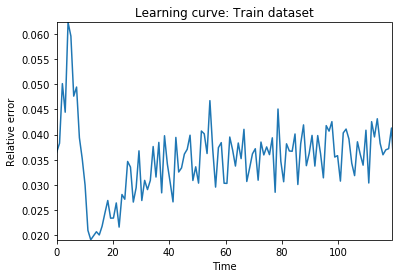

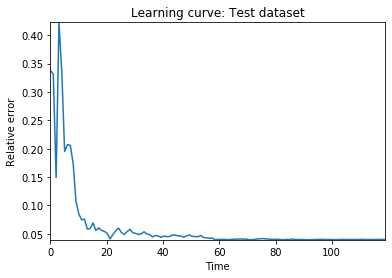

In [12]:
############ STEP 1.4.1 #############################################
save = True  # Should we save the following figs? 
filename_train = mySom.name + "_err_train"   # Names of the files of the saved figs
filename_test = mySom.name + "_err_test"

print_error(mySom.relerr_train,legend="Learning curve: Train dataset",save=save, path=path_fig, filename=filename_train)
print_error(mySom.relerr_test,legend="Learning curve: Test dataset",save=save, path=path_fig, filename=filename_test)

###### 1.4.2 Weights visualization

Here we will plot some features of the weights of the SOM and try to answer some of the previous questions:

__Question 1:__
Are similar weights close to each other - resulting in specialized areas in the map - as they should in a SOM?
- If there are some discontinuities from one weight to its neighbors then the internal structure of the SOM is really really bad.
    - A problem with the neighborhood function? => this function should return 1. when applied to the BMU itself, decrease with respect to the distance of the BMU and be positive.
    - Wrong initialization of ``distance_matrix`` (defines the distance between classes)? => This function should always be positive, symmetric, and decrease with respect to the distance within the SOM
    - learning rate extremely low => The training never really updates the weights
    - radius extremely low? Even the direct neighbors are not really affected by the update
    

- 2 areas share the common features (same average and standard deviation) but are located at 2 different positions in the SOM then there are 2 areas that are speciliazed in the same functionality while there sould be only one.
    - A radius too low?
    - ratio ``m/n`` not consistent with the data?

__Questions 2:__
Are some neurons redundant? Are some periods of year well represented while some others are poorly represented?
- There is a very large area of extremely similar weights (e.g. representing the winter) while the others areas are "squeezed" into the SOM then these neurons might be redundant and winter is probably the only well represented period.
    - ratio ``m/n`` not consistent with the data?
    - training dataset not representative of a given period? (In case of sparse time series, there could be a lot of missing vectors during the summer for instance resulting in a SOM unable to represent the summer) 
    
<span style="background-color: ##FFFF00">**NOTE**: </span>

You can compare these figures with the ones obtained after the weights initialization at step 1.2.3 to see the impact of the training on the SOM 

DATA TYPE :  sst
VALUE OF EVERY WEIGHT OF THE SOM 


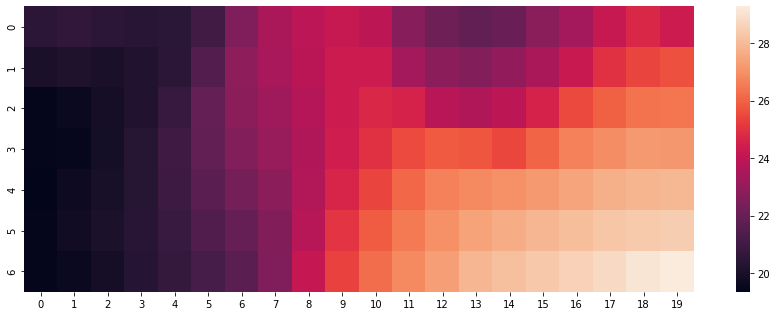

DATA TYPE :  dswr
VALUE OF EVERY WEIGHT OF THE SOM 


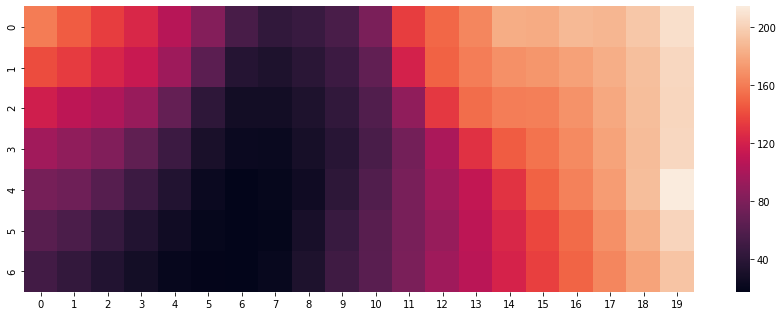

In [13]:
############ STEP 1.4.2 #############################################

mySom.clear_map_info()

if not surface or p>1:
    # If we are using observable variables, each element of the vector represents a different type of data
    # and should be treated separately
    if surface:
        for i in range(nb_data_types_used):
            print("DATA TYPE : ", data_types[data_types_used[i]])
            print("VALUE OF EVERY WEIGHT OF THE SOM ")
            weights_mean = mySom.weights_features(features="mean",start=i,end=i+1)
            mySom.print_heatmap(weights_mean)
            
    # If we are using hidden variables, each element of the vector represents a different level of depth 
    # of the temperature vertical profile and we can "average" them to make the plotting easier to interpret 
    else:
        print("TEMPERATURE, AVERAGE VALUE (ALL LEVELS OF DEPTH) OF EVERY WEIGHT OF THE SOM ")
        weights_mean = mySom.weights_features(features="mean")
        mySom.print_heatmap(weights_mean)
        print("TEMPERATURE, STANDARD DEVIATION (ALL LEVELS OF DEPTH) OF EVERY WEIGHT OF THE SOM ")
        weights_dev = mySom.weights_features("std")
        mySom.print_heatmap(weights_dev)
        parts = 4  # the whole profiles will be decomposed into 4 smaller profiles 
        for i in range(parts):
            start=i*p//parts
            end=(i+1)*p//parts
            print("TEMPERATURE, AVERAGE VALUE(LEVELS OF DEPTH", p-start, "TO", p-end,")" )
            weights_mean = mySom.weights_features(features="mean",start=start,end=end)
            mySom.print_heatmap(weights_mean)
            print("TEMPERATURE, STANDARD DEVIATION (LEVELS OF DEPTH", p-start, "TO", p-end,")" )
            weights_std = mySom.weights_features(features="std",start=start,end=end)
            mySom.print_heatmap(weights_std)

###### 1.4.3 SOM outputs

Here are the outputs of our SOM for the complete dataset. The following plots should help to answer these questions:

__Question 1:__
Is there a problem of overfitting/underfitting?

- Compare the results obtained with the training dataset (here the years ``1992-1992+nb_years_train-1``) and the testing dataset (the last ``nb_years-nb_years_train years``). If the first one is far better than the second one then there is a problem of overfitting. 
    - learning rate too high? => If the learning rate is really close to 1. then the weights can result in a sort of sample the training dataset - which works well to map the training dataset but not to map new inputs.
    - ``epochs`` too high?
    - total number of classes ``n*m`` too high? => If the total number of classes is really high (close to the number of training inputs) then each weight can be the representant of one training input instead of a representant of one feature in the data, being then less adaptative.

__Question 2:__
Are outputs of the SOM representative of the inputs?

Compare the SOM outputs with the "real" data. 
- If the SOM outputs are not representative enough of the data, even on the training dataset
  - ``n*m`` too low? => There is not enough classes, only the very main features are represented by the weights missing a lot of important nuances. 
- If the SOM outputs are not representative enough but only on the testing dataset then there is a problem of overfitting, cf first question.


__Question 3:__
Are some periods of year well represented while some others are poorly represented?

- Compare the SOM outputs with the "real" data for each period of the year. If - for instance - the autumn and winter are always well represented while the summer is only represented with the same classes regardless of the year being mapped then:     
    - ratio ``m/n`` not consistent with the data? => If the shape is not consistent with the data, it will be difficult for the areas to specialize according to the different main features of the data. 
    - training dataset not representative? => In case of sparse time series, there could be a lot of missing vectors during the summer for instance resulting in a SOM unable to represent the summer


__Question 4:__
Can the SOM represent well enough extreme inputs (very high/low temperature? High on the surface and low in the deep subsurface? )

- Compare the SOM outputs with the "real" data when the "real" data is extreme. If the outputs seem to be capped:
    - ratio ``m/n`` not consistent with the data? => (cf previous question)
    - total number of classes ``n*m`` too low? => (cf question 2)
    - training dataset not representative of extreme values? => (cf previous question)
    - learning rate too low? The weights will learn slowly and might be able to represent well a vector that is close to the average (climatology) but no weight can represent extreme values because they take longer to learn.
    - radius too high? => Each input vector will affect too many classes around the BMU. As a result all the neurons are an average of too many inputs and can not represent extreme inputs anymore.

74  vectors mapped in  0.09  sec


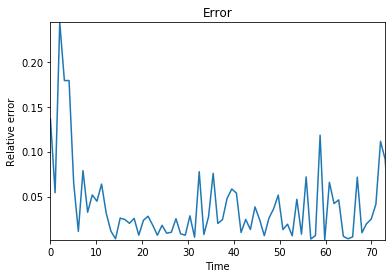

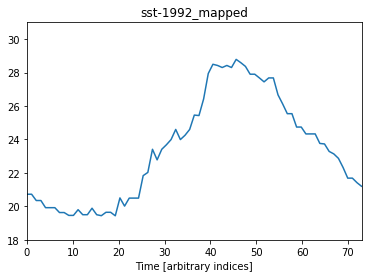

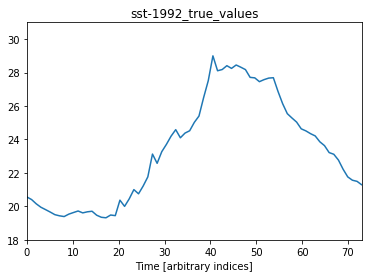

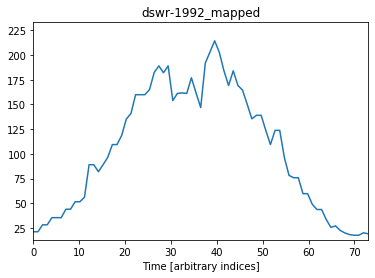

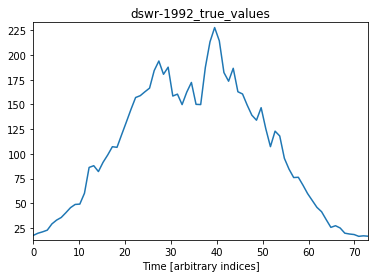

73  vectors mapped in  0.08  sec


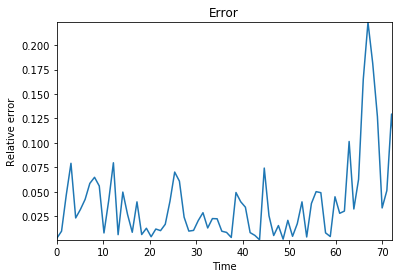

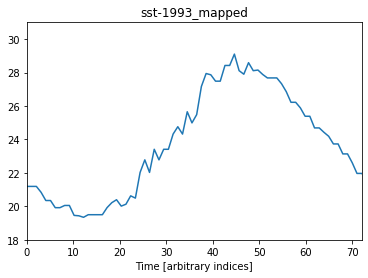

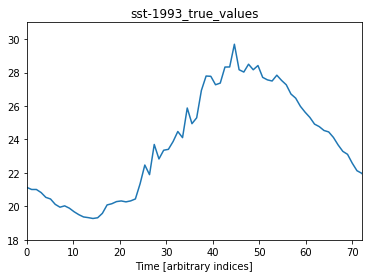

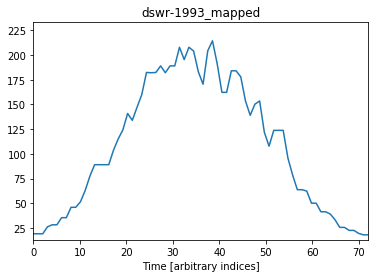

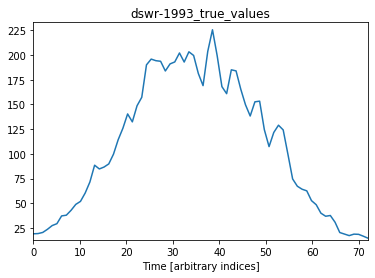

73  vectors mapped in  0.08  sec


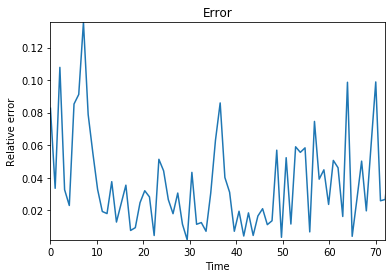

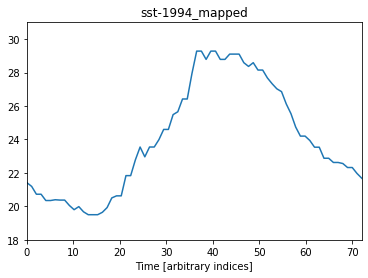

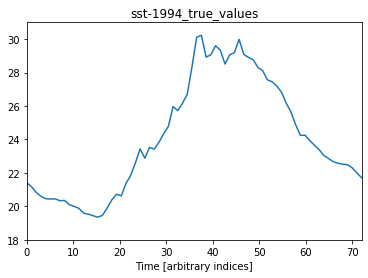

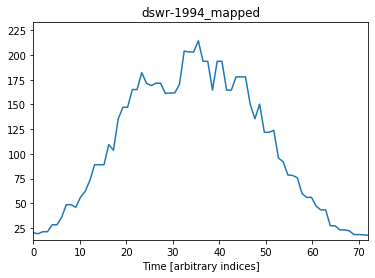

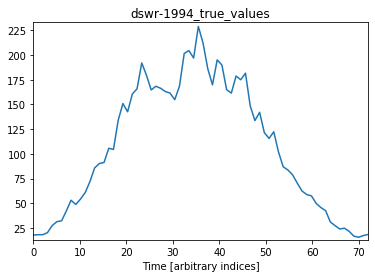

73  vectors mapped in  0.09  sec


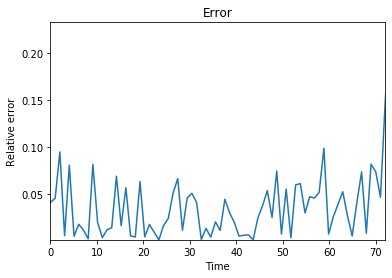

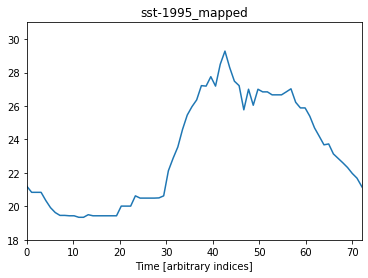

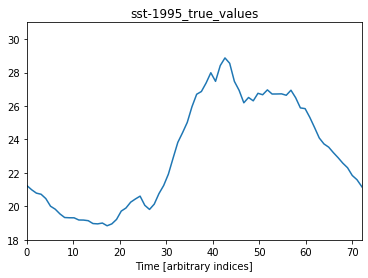

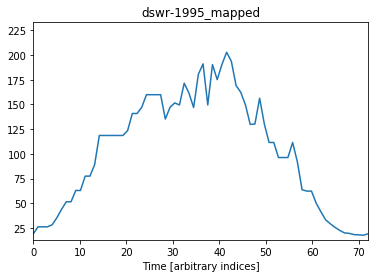

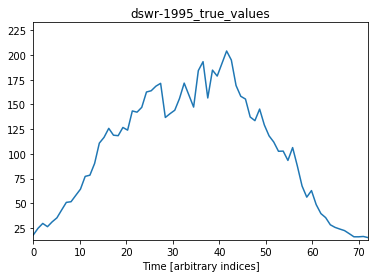

74  vectors mapped in  0.08  sec


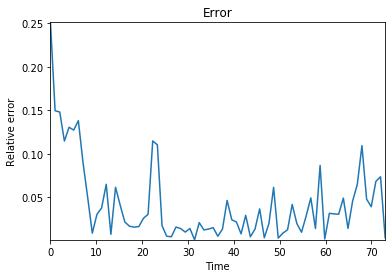

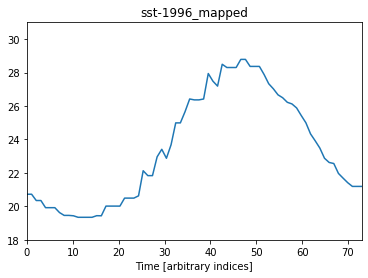

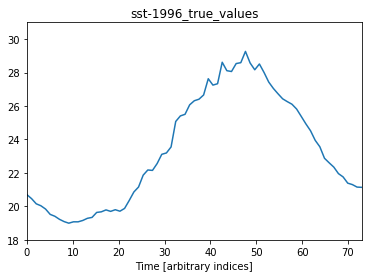

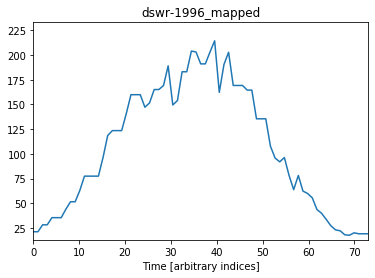

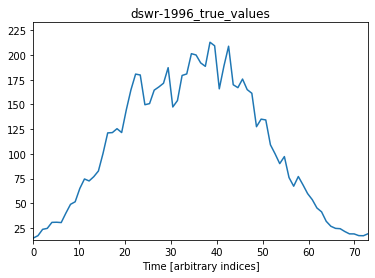

73  vectors mapped in  0.08  sec


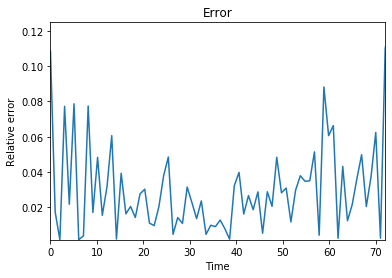

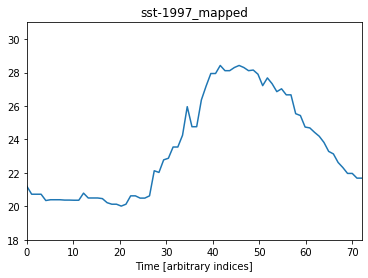

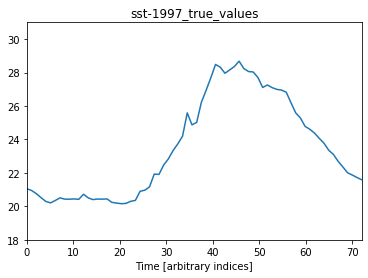

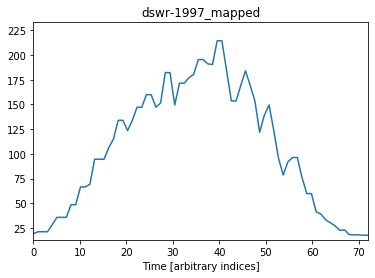

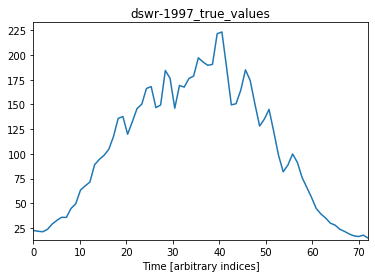

73  vectors mapped in  0.08  sec


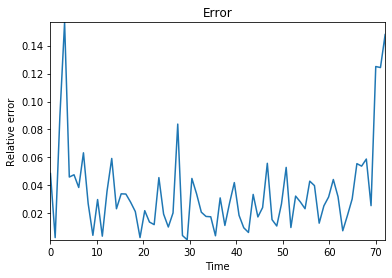

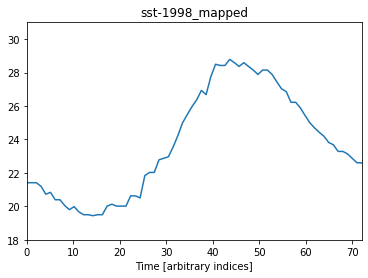

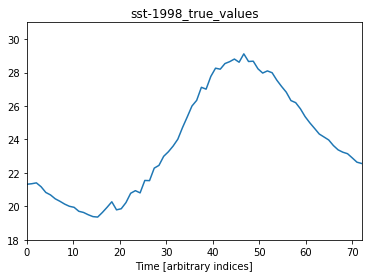

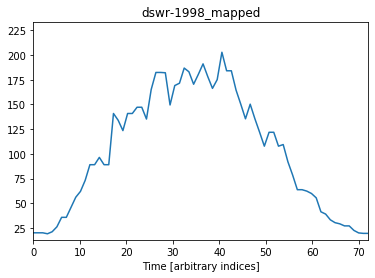

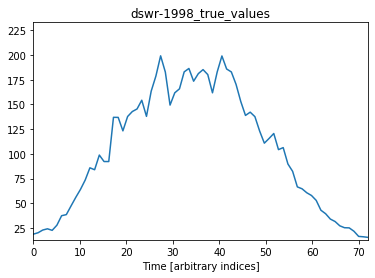

73  vectors mapped in  0.08  sec


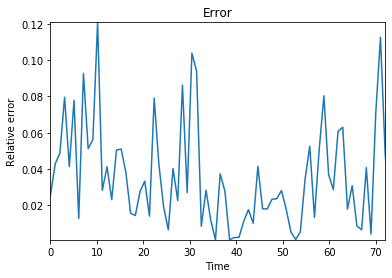

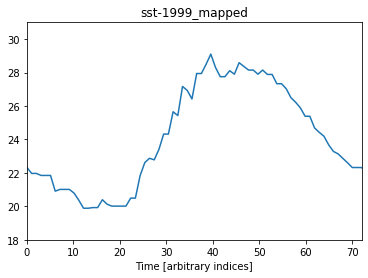

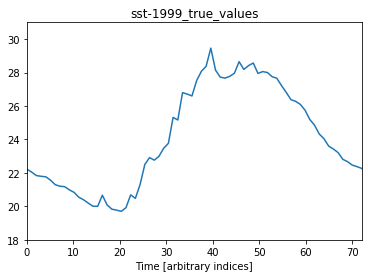

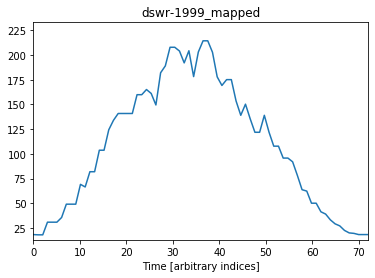

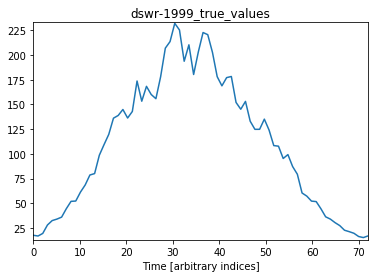

74  vectors mapped in  0.08  sec


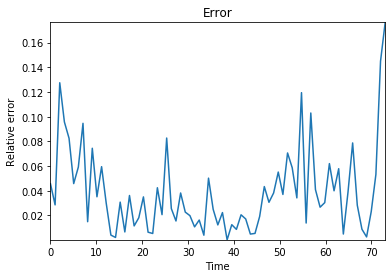

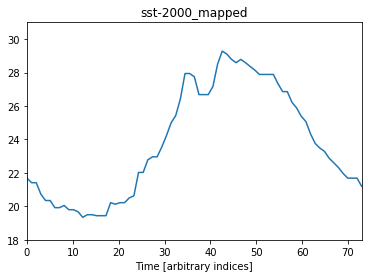

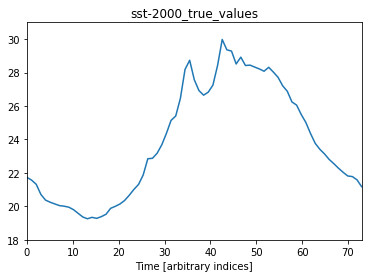

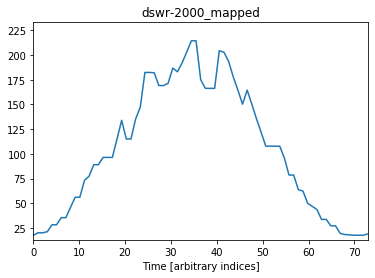

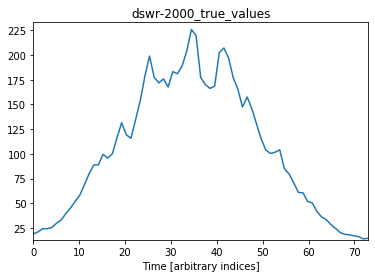

73  vectors mapped in  0.08  sec


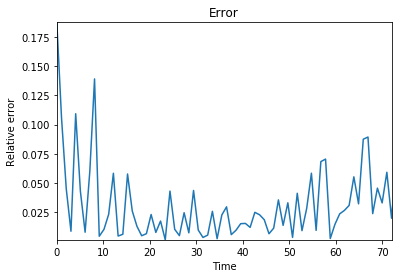

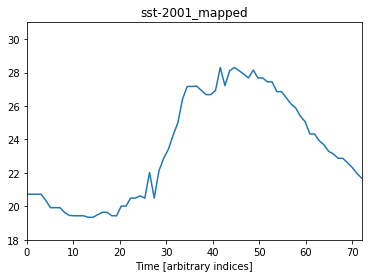

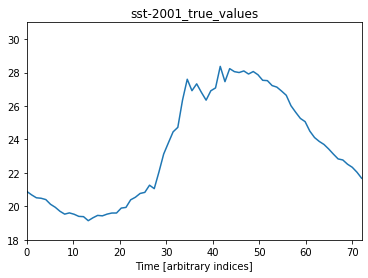

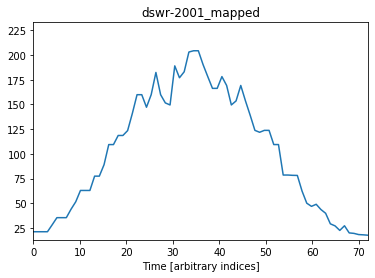

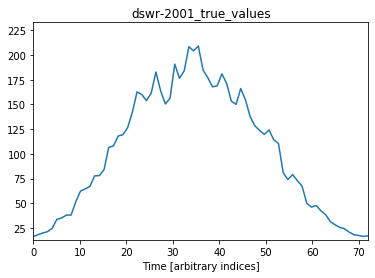

73  vectors mapped in  0.08  sec


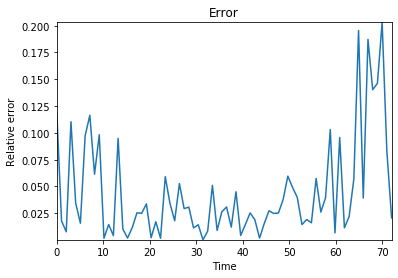

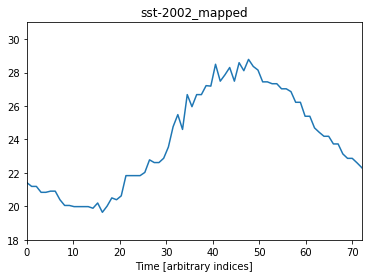

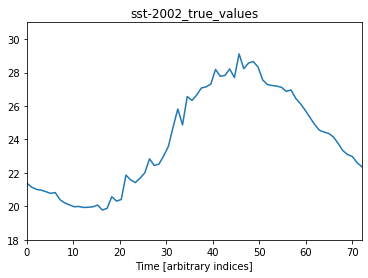

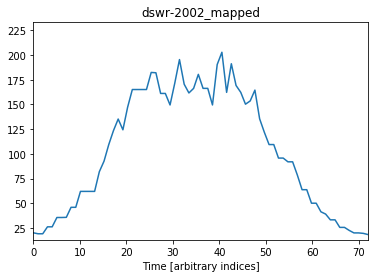

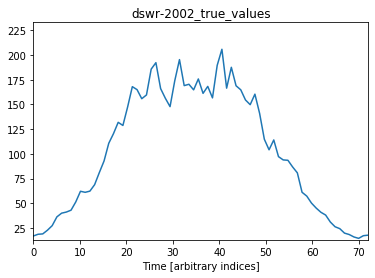

73  vectors mapped in  0.08  sec


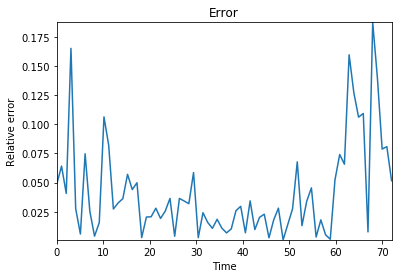

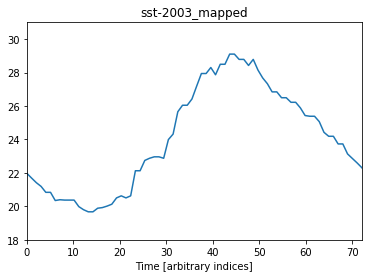

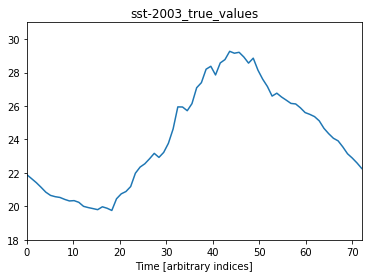

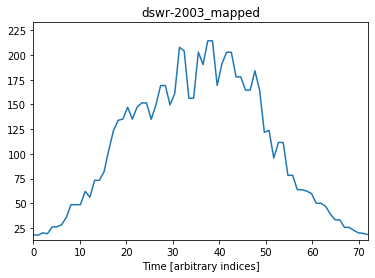

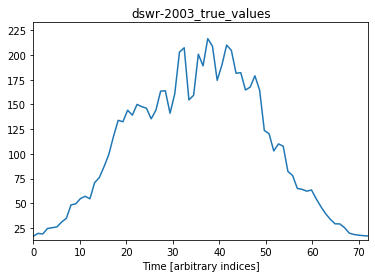

74  vectors mapped in  0.09  sec


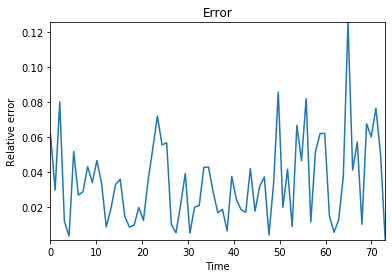

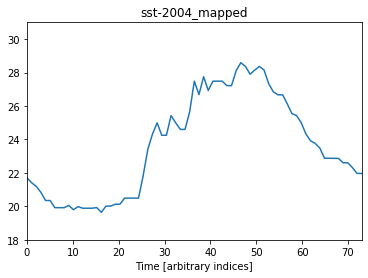

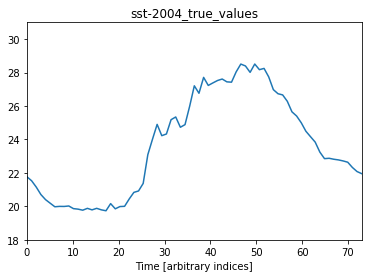

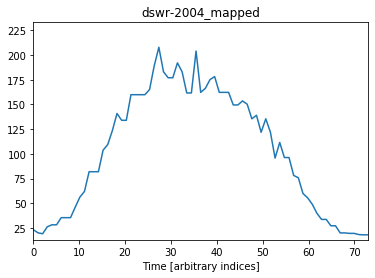

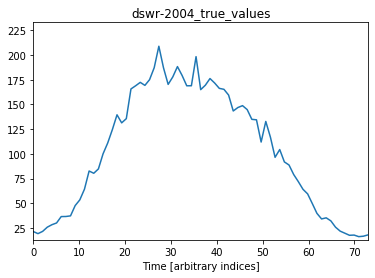

73  vectors mapped in  0.09  sec


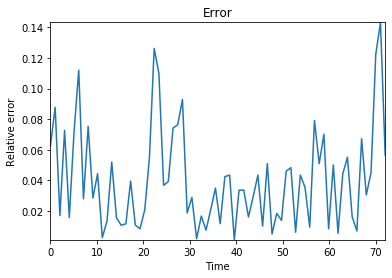

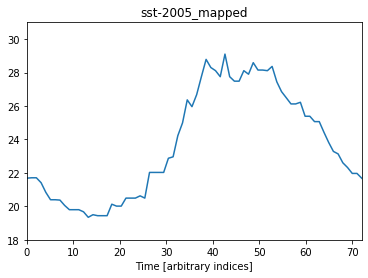

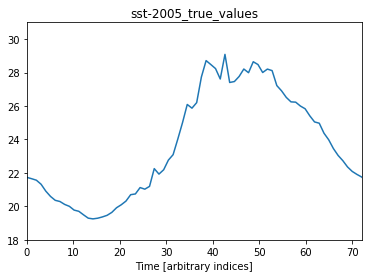

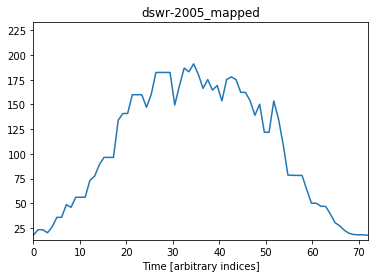

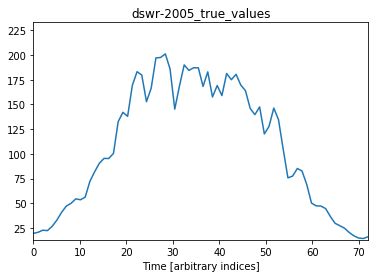

73  vectors mapped in  0.08  sec


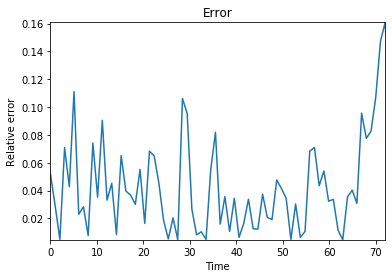

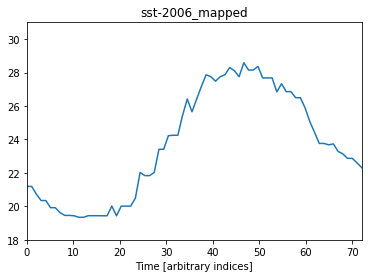

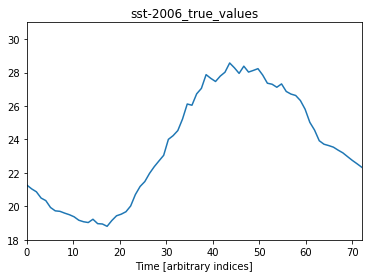

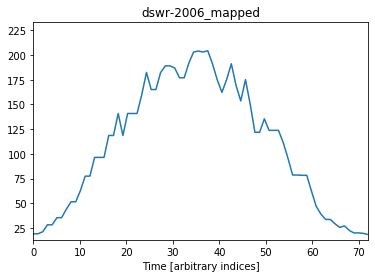

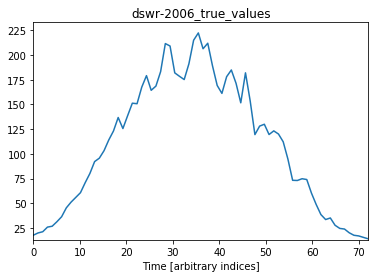

72  vectors mapped in  0.08  sec


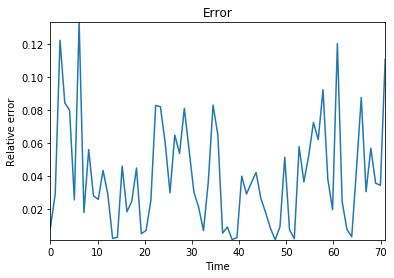

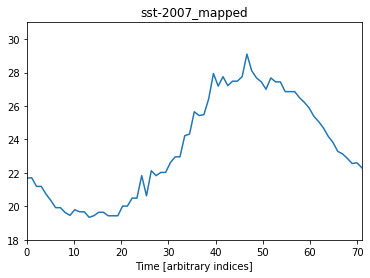

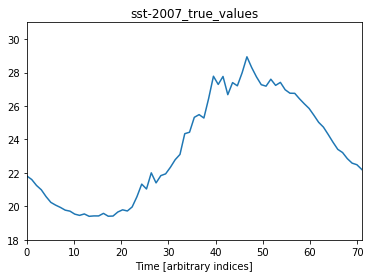

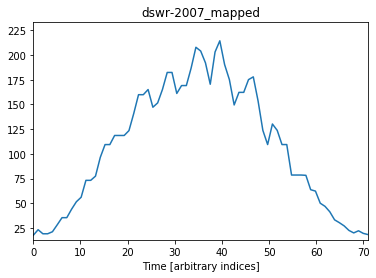

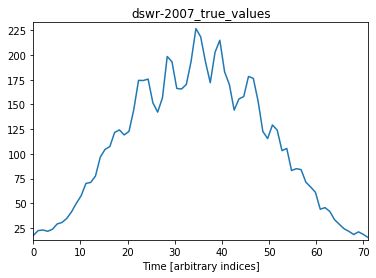

In [14]:
############ STEP 1.4.3 #############################################
mySom.clear_map_info()

for y in range(0,nb_years):
    inputs = data_map_norm[y]
    name=str(1992+y)+"_mapped"
    # map the data with our trained SOM "mySom"
    myMap = map2d.Map2d(som=mySom, name=name)
    myMap.map_from_data(inputs,overwrite=True)
    name_err = name + "_err"
    # print the mapping error 
    print_error(myMap.relerr, save=save,path=path_fig,filename=name_err)
    if surface:
        # If we are using observable variable, each element of the vector represents a different type of data
        # and should be treated separately
        for i in range(nb_data_types_used):
            zmin=int(data_min[i])  
            zmax=int(data_max[i])+1
            
            # print SOM output
            legend=data_types[data_types_used[i]] + "-"+str(1992+y)+"_mapped"
            name_i = name+"_"+data_types[data_types_used[i]]
            print_data(myMap.values[:,i],
                       legend=legend, save=save, path=path_fig, filename=name_i ,zmin=zmin,zmax=zmax)
            
            # print the corresponding true values (SOM inputs)
            legend=data_types[data_types_used[i]] + "-"+str(1992+y)+"_true_values"
            print_data(myMap.true_values[:,i],legend=legend,zmin=zmin,zmax=zmax)
    else:
        zmin=int(data_min[0])
        zmax=int(data_max[0])+1
        
        # print SOM output
        legend="temp-"+str(1992+y)+"_mapped"   
        print_data(myMap.values, 
                   depth, legend=legend, save=save,path=path_fig, filename=name,zmin=zmin,zmax=zmax)
        
        # print the corresponding true values (SOM inputs)
        legend="temp-"+str(1992+y)+"_true_values"
        print_data(myMap.true_values, depth,legend=legend,zmin=zmin,zmax=zmax)        

###### 1.4.4 SOM properties: occurence BMU

<span style="background-color: ##FFFF00">**NOTE**:</span>
The testing dataset is smaller than the training one, so it is normal if there are more classes that are unused for mapping the testing dataset!

__Question 1:__
Are some areas used too often while some are never used for mapping?

- If some areas (and not only some classes here and there) are not used at all for mapping the entire datasets:
  - ratio ``m/n`` not consistent with the data? SOM too thin? => If the SOM is thin, the distance between one side to the opposite one can be very long. It can be a good thing if there are a lot of very different and small areas to train. Otherwise it can result in "holes" in the SOM
  - total number of classes ``n*m`` too high? => Some areas are never trained because there are enough neurons too represent well the training dataset in others areas. 
  - radius too low? => The neurons in the unused areas have never been the BMU and they are too far away from the BMU with respect to the radius to be trained enough through the neighborhood function
- If the BMU are mostly near the border of the SOM:
  - ratio ``m/n`` not consistent with the data? SOM too "square"? => Areas that are representing very different inputs tend to repel each other. For the same number of classes, the distance between two areas can be longer in a thin rectangle than in a square
  - radius too high? => The radius that are in the center of the map are averaged by too many neurons and only those on the borders or corners are specialized and representative because they are less affected by their neighbors
  - learning rate too low? => Neurons are not specialized enough at the end of the training if the learning rate has been too low throughout the training
  - training dataset non representative? => If this problem happens only with the testing dataset it might be because there are not such extreme inputs in the training dataset


 ########################### OCCURENCE BMU ################################ 

 ########################### TESTING DATASET  ################################
292  vectors mapped in  0.2  sec
Number of input vectors mapped:  292
Total number of classes:   140
Number of classes that were NOT used to map the whole testing dataset:  42
OCCURENCE BMU: 


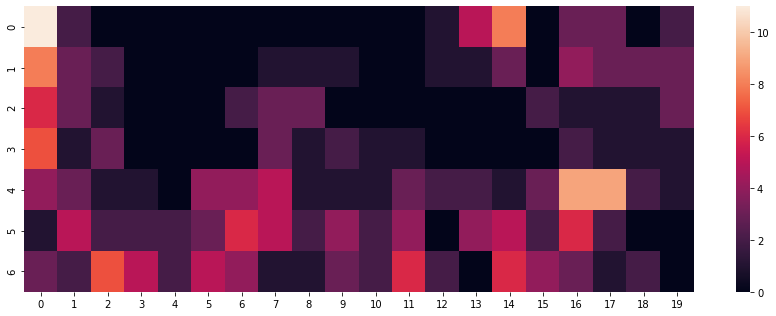

 ########################### TRAINING DATASET  ################################
879  vectors mapped in  0.45  sec
Number of input vectors mapped:  879
Total number of classes:   140
Number of classes that were NOT used to map the whole training dataset:  12
OCCURENCE BMU: 


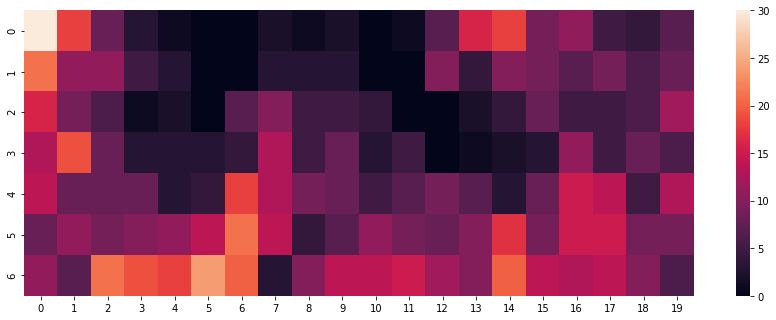

In [15]:
############ STEP 1.4.4 #############################################

mySom.clear_map_info()

print(" ########################### OCCURENCE BMU ################################ \n")

print(" ########################### TESTING DATASET  ################################")
inputs = np.concatenate(data_map_norm[nb_years_train:])
name=str(1992+nb_years_train)+"-2007_mapped"
map_test = map2d.Map2d(som=mySom,name=name)
map_test.map_from_data(inputs)

print("Number of input vectors mapped: ", map_test.nb_inputs_mapped)
print("Total number of classes:  ", map_test.nb_class)
print("Number of classes that were NOT used to map the whole testing dataset: ", n*m-map_test.nb_classes_used)
print("OCCURENCE BMU: ")
res = mySom.print_heatmap(data=map_test.som.occ_bmu_map)

print(" ########################### TRAINING DATASET  ################################")
inputs = np.concatenate(data_map_norm[:nb_years_train])
name="1992-"+str(1992+nb_years_train-1)+"_mapped"
map_train = map2d.Map2d(som=mySom,name=name)
map_train.map_from_data(inputs)

print("Number of input vectors mapped: ", map_train.nb_inputs_mapped)
print("Total number of classes:  ", map_train.nb_class)
print("Number of classes that were NOT used to map the whole training dataset: ", n*m-map_train.nb_classes_used)
print("OCCURENCE BMU: ")
res = mySom.print_heatmap(data=map_train.som.occ_bmu_map)

###### 1.4.5 SOM properties: transitions

__Question:__
Are transitions between the BMU at instant ``t`` and ``t-1`` are mostly short/long?

__Question:__
Is the standard deviation of the distance of transiton low/high?

__Question:__
Are similar weights close to each other - resulting in specialized areas in the map - as they should in a SOM?

 ###########################  TRANSITIONS ################################ 

 ########################### TESTING DATASET  ################################
Mean distance convered by transitions: 1.302059492949148
Standard deviation of the distance covered by transitions: 1.8599140442716
DISTANCE TRANSITION: 


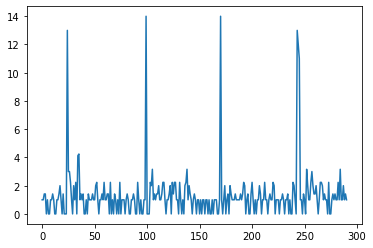

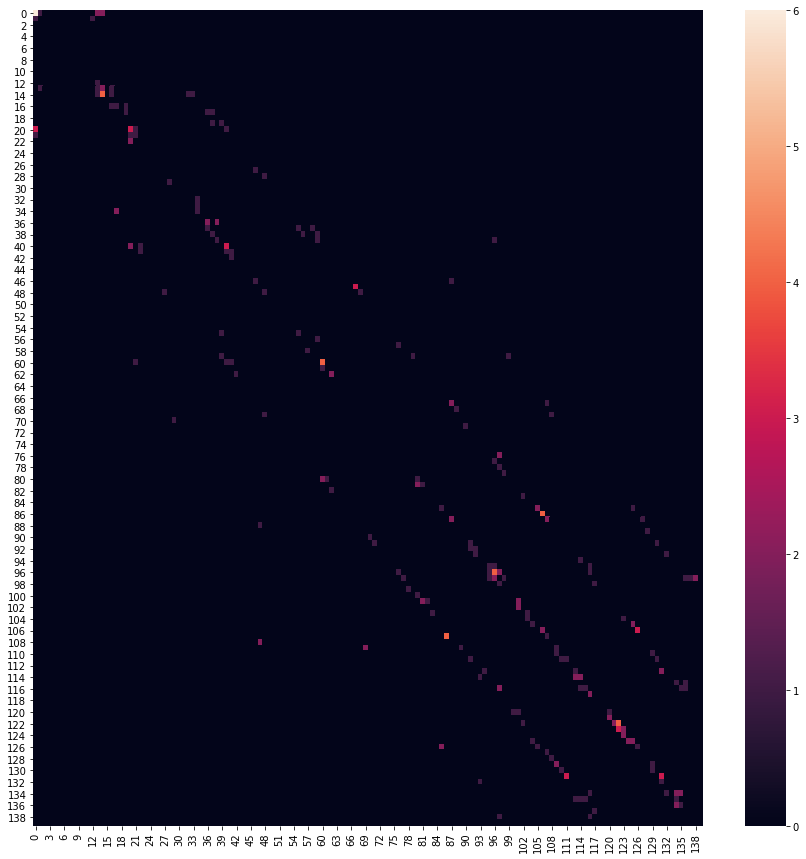

 ########################### TRAINING DATASET  ################################
Mean distance convered by transitions: 1.2424141702924318
Standard deviation of the distance covered by transitions: 1.6532308989704927
DISTANCE TRANSITION: 


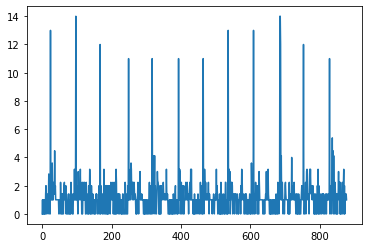

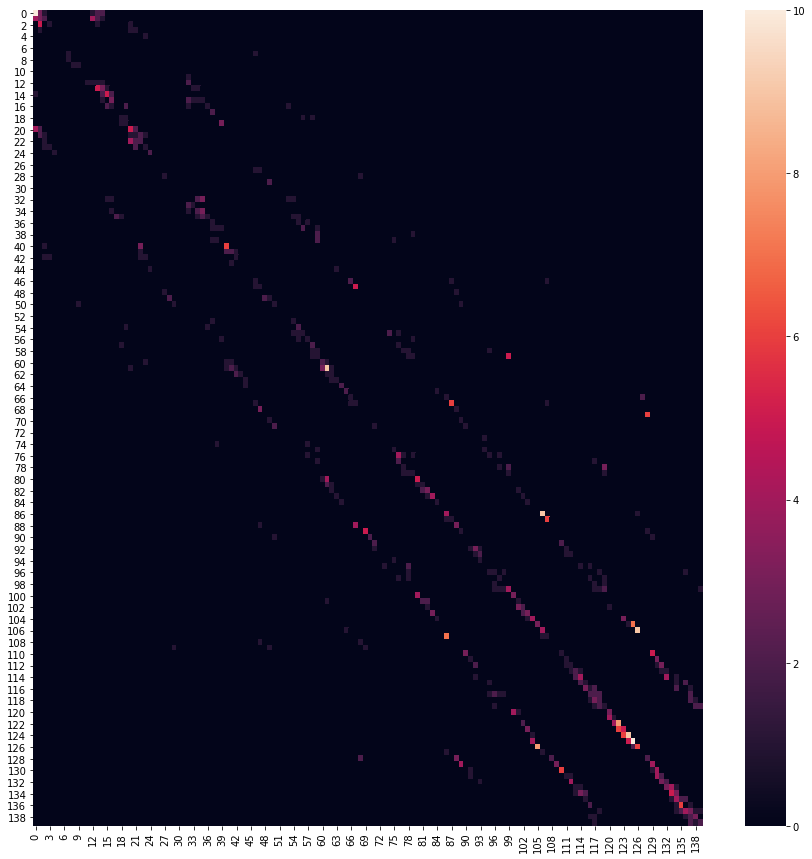

In [16]:
############ STEP 1.4.5 #############################################

print(" ###########################  TRANSITIONS ################################ \n")

print(" ########################### TESTING DATASET  ################################")

print("Mean distance convered by transitions:", np.mean(map_test.distance_transitions))
print("Standard deviation of the distance covered by transitions:", np.std(map_test.distance_transitions))
print("DISTANCE TRANSITION: ")
plt.plot(map_test.distance_transitions)
# Transition matrix
fig1= plt.figure(figsize=(15,15))
sns.heatmap(map_test.transition, annot=False)
plt.show()


print(" ########################### TRAINING DATASET  ################################")

print("Mean distance convered by transitions:", np.mean(map_train.distance_transitions))
print("Standard deviation of the distance covered by transitions:", np.std(map_train.distance_transitions))
print("DISTANCE TRANSITION: ")
fig=plt.figure()
plt.plot(map_train.distance_transitions)
# Transition matrix
fig2= plt.figure(figsize=(15,15))
sns.heatmap(map_train.transition, annot=False)
plt.show()

**If you are satisfied with the results you can save your Som and Map2d objects! :)**

In [17]:
save=True
# Save the SOM with map_info generated only with the training dataset
mySom.clear_map_info()
inputs = np.concatenate(data_map_norm[:nb_years_train])
mySom.map(inputs)
som.save(mySom, path=path_som)

save=True
# Save a Map2d object for each year of the entire dataset
for y in range(nb_years):
    name=str(1992+y)+"_mapped"
    inputs = data_map_norm[y]
    newMap = map2d.Map2d(som=mySom,name=name)
    newMap.map_from_data(inputs)
    if save:
        map2d.save(newMap, path=path_map)

save = True
# Save the Map2d corresponding to the entire training dataset  
inputs = np.concatenate(data_map_norm[:nb_years_train])
name="1992-"+str(1992+nb_years_train-1)+"_mapped"
map_tot = map2d.Map2d(som=mySom,name=name)
map_tot.map_from_data(inputs)
if save:
    map2d.save(map_tot, path=path_map)
    
save=True
# Save the Map2d corresponding to the entire testing dataset  
inputs = np.concatenate(data_map_norm[nb_years_train:])
name=str(1992+nb_years_train)+"-2007_mapped"
map_tot = map2d.Map2d(som=mySom,name=name)
map_tot.map_from_data(inputs)
if save:
    map2d.save(map_tot, path=path_map)

879  vectors mapped in  0.45  sec
74  vectors mapped in  0.08  sec
73  vectors mapped in  0.09  sec
73  vectors mapped in  0.08  sec
73  vectors mapped in  0.09  sec
74  vectors mapped in  0.09  sec
73  vectors mapped in  0.09  sec
73  vectors mapped in  0.09  sec
73  vectors mapped in  0.09  sec
74  vectors mapped in  0.09  sec
73  vectors mapped in  0.09  sec
73  vectors mapped in  0.09  sec
73  vectors mapped in  0.08  sec
74  vectors mapped in  0.09  sec
73  vectors mapped in  0.09  sec
73  vectors mapped in  0.1  sec
72  vectors mapped in  0.09  sec
879  vectors mapped in  0.47  sec
292  vectors mapped in  0.2  sec
